<a href="https://colab.research.google.com/github/AliARajabi/deep-learning/blob/main/ResNet50/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input,ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, Flatten, Dense, AveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform

# **The identity block**

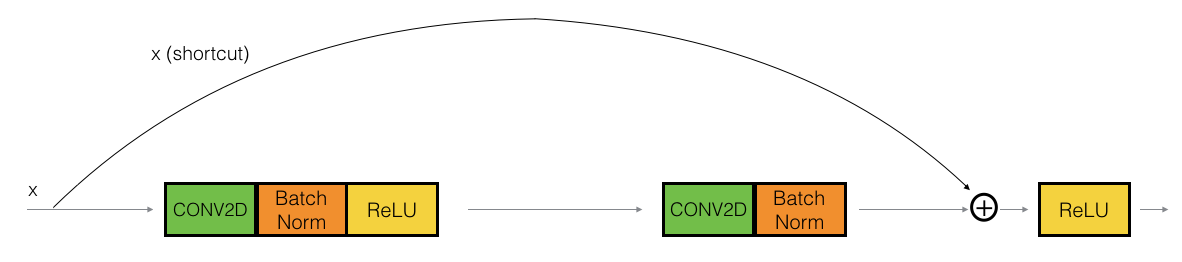

**Identity block.** Skip connection "skips over" 2 layers.

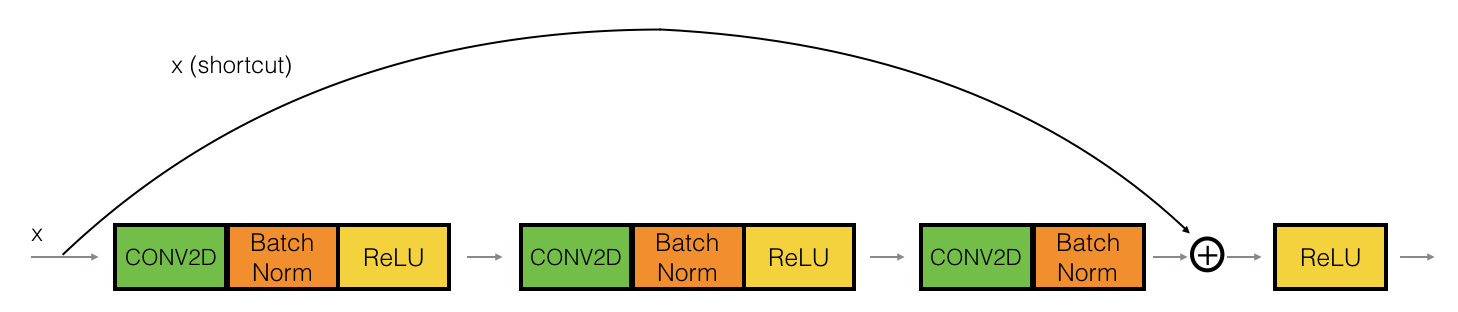

**Identity block.** Skip connection "skips over" 3 layers

Here are the individual steps.

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2a'`. Use 0 as the seed for the random initialization. 
- The first BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same" and its name should be `conv_name_base + '2b'`. Use 0 as the seed for the random initialization. 
- The second BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2c'`. Use 0 as the seed for the random initialization. 
- The third BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2c'`. 
- Note that there is **no** ReLU activation function in this component. 

Final step: 
- The `X_shortcut` and the output from the 3rd layer `X` are added together.
- **Hint**: The syntax will look something like `Add()([var1,var2])`
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

In [9]:
def Idendity_block(x,f, filters,stage, block):
  X_per=x

  #names
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  F1, F2, F3 = filters

  #first stage
  x = Conv2D(filters=F1,kernel_size=1,name=conv_name_base + '2a',kernel_initializer=GlorotUniform(seed=0))(x)
  x = BatchNormalization(axis=3,name=bn_name_base + '2a')(x)
  x = Activation('relu')(x)

  #second stage
  x = Conv2D(filters=F2,kernel_size=f,name=conv_name_base + '2b',padding='same',kernel_initializer=GlorotUniform(seed=0))(x)
  x = BatchNormalization(axis=3,name=bn_name_base + '2b')(x)
  x = Activation('relu')(x)

  #third stage
  x = Conv2D(filters=F3,kernel_size=1,name=conv_name_base + '2c',kernel_initializer=GlorotUniform(seed=0))(x)
  x = BatchNormalization(axis=3,name=bn_name_base + '2c')(x)

  #final stage
  x = Add()([x,X_per])
  x = Activation('relu')(x)

  return x


# **The convolutional block**

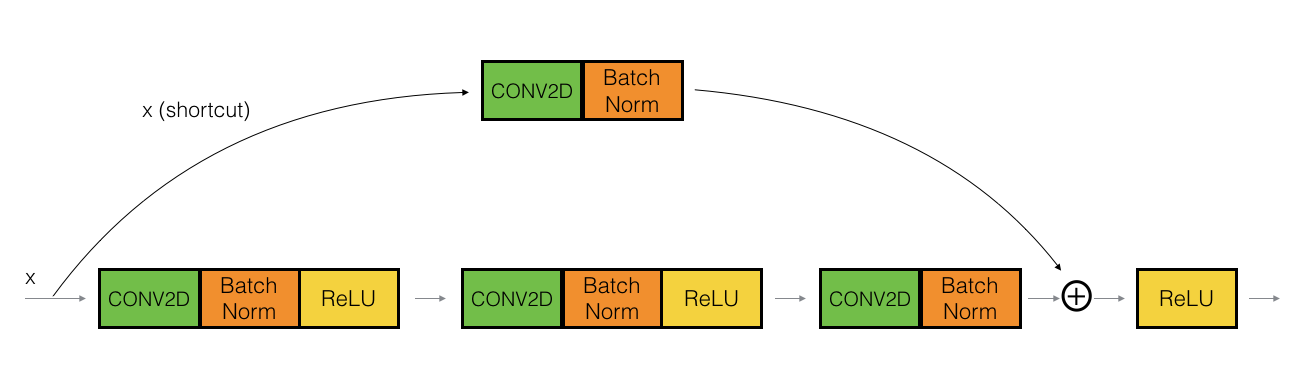

**Convolutional block**

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '2a'`. Use 0 as the `glorot_uniform` seed.
- The first BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same" and it's name should be `conv_name_base + '2b'`.  Use 0 as the `glorot_uniform` seed.
- The second BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and it's name should be `conv_name_base + '2c'`.  Use 0 as the `glorot_uniform` seed.
- The third BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2c'`. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '1'`.  Use 0 as the `glorot_uniform` seed.
- The BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '1'`. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 
    

In [10]:
def Convolutional_block(x,f, filters,stage, block,s=2):
  X_per=x

  #names
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  F1, F2, F3 = filters

  #first stage
  x = Conv2D(filters=F1,kernel_size=1,strides=s,name=conv_name_base + '2a',kernel_initializer=GlorotUniform(seed=0))(x)
  x = BatchNormalization(axis=3,name=bn_name_base + '2a')(x)
  x = Activation('relu')(x)

  #second stage
  x = Conv2D(filters=F2,kernel_size=f,padding='same',name=conv_name_base + '2b',kernel_initializer=GlorotUniform(seed=0))(x)
  x = BatchNormalization(axis=3,name=bn_name_base + '2b')(x)
  x = Activation('relu')(x)

  #third stage
  x = Conv2D(filters=F3,kernel_size=1,name=conv_name_base + '2c',kernel_initializer=GlorotUniform(seed=0))(x)
  x = BatchNormalization(axis=3,name=bn_name_base + '2c')(x)

  #shortcut path
  X_per = Conv2D(filters=F3,kernel_size=1,strides=s,name=conv_name_base + '1',kernel_initializer=GlorotUniform(seed=0))(X_per)
  X_per = BatchNormalization(axis=3,name=bn_name_base + '1')(X_per)

  #final stage
  x = Add()([x,X_per])
  x = Activation('relu')(x)

  return x

# **ResNet model (50 layers)**

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
    - BatchNorm is applied to the 'channels' axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
    - The 2 identity blocks use three sets of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    - The 3 identity blocks use three sets of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
- The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
- The 'flatten' layer doesn't have any hyperparameters or name.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be `'fc' + str(classes)`.

In [11]:
def ResNet50(inputShape=(28,28,3),classes=3):
  '''
  architecture:
  CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

  Arguments:
  input_shape -- shape of the images of the dataset
  classes -- integer, number of classes

  Returns:
  model -- a Model() instance in Keras
  '''
  input_x = Input(inputShape)

  X = ZeroPadding2D(padding=(3,3))(input_x)

  # stage 1:
  X = Conv2D(filters = 64,kernel_size = 7,strides = 2,name = 'conv1', kernel_initializer = GlorotUniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D(pool_size = (3,3),strides = 2)(X)

  #stage 2:
  X = Convolutional_block(X, f = 3, filters = [64,64,256], stage = 2 , block = 'a', s = 1)
  X = Idendity_block(X, f = 3 , filters = [64,64,256] , stage = 2, block = 'b')
  X = Idendity_block(X, f = 3 , filters = [64,64,256] , stage = 2, block = 'c')

  #stage 3:
  X = Convolutional_block(X, f = 3, filters = [128,128,512], stage = 3 , block = 'a', s = 2)  
  X = Idendity_block(X, f = 3 , filters = [128,128,512] , stage = 3, block = 'b')
  X = Idendity_block(X, f = 3 , filters = [128,128,512] , stage = 3, block = 'c')
  X = Idendity_block(X, f = 3 , filters = [128,128,512] , stage = 3, block = 'd')

  #stage 4:
  X = Convolutional_block(X, f = 3, filters = [256,256,1024], stage = 4 , block = 'a', s = 2)  
  X = Idendity_block(X, f = 3 , filters = [256,256,1024] , stage = 4, block = 'b')
  X = Idendity_block(X, f = 3 , filters = [256,256,1024] , stage = 4, block = 'c')
  X = Idendity_block(X, f = 3 , filters = [256,256,1024] , stage = 4, block = 'd') 
  X = Idendity_block(X, f = 3 , filters = [256,256,1024] , stage = 4, block = 'e')
  X = Idendity_block(X, f = 3 , filters = [256,256,1024] , stage = 4, block = 'f')  

  #stage 5:
  X = Convolutional_block(X, f = 3, filters = [512,512,2048], stage = 5 , block = 'a', s = 2)  
  X = Idendity_block(X, f = 3 , filters = [512,512,2048] , stage = 5, block = 'b')
  X = Idendity_block(X, f = 3 , filters = [512,512,2048] , stage = 5, block = 'c')

  # average pooling:
  X = AveragePooling2D(name = 'avg_pool')(X)

  # dence layer:
  X = Flatten()(X)
  X = Dense(classes , activation='softmax' , name = 'fc' + str(classes) , kernel_initializer=GlorotUniform(seed=0))(X)

  model = Model(inputs = input_x , outputs = X, name='ResNet50')

  return model

In [20]:

def ArdruResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = GlorotUniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = Convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = Idendity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = Idendity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3
    X = Convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = Idendity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = Idendity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = Idendity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = Convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = Idendity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = Idendity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = Idendity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = Idendity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = Idendity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = Convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = Idendity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = Idendity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # Average Pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = GlorotUniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

#test the renet50 

In [6]:
model = ResNet50(inputShape = (64,64,3), classes = 6)

In [8]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [13]:
model.compile(optimizer = 'adam' ,loss = 'categorical_crossentropy' , metrics = ['accuracy'])

NameError: ignored

In [14]:
!git clone https://github.com/AliARajabi/deep-learning.git

Cloning into 'deep-learning'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 83 (delta 20), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (83/83), done.


In [15]:
import h5py
train_d = h5py.File('/content/deep-learning/sign language using CNN/train_signs.h5','r')
x_train = np.array(train_d["train_set_x"])
y_train = np.array(train_d["train_set_y"])

test_d = h5py.File('/content/deep-learning/sign language using CNN/test_signs.h5','r')
x_test = np.array(test_d["test_set_x"])
y_test = np.array(test_d["test_set_y"])
classes=np.array(train_d["list_classes"])
print(classes)

[0 1 2 3 4 5]


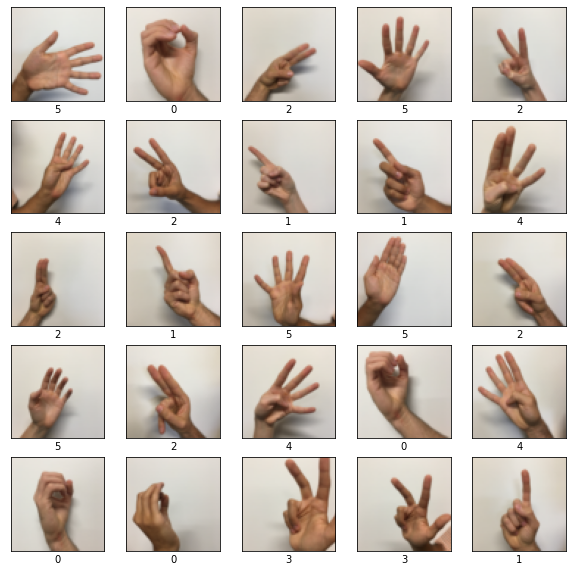

In [16]:


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()



In [17]:
x_train = x_train/255
x_test = x_test/255

In [18]:
y_train = np.eye(len(classes))[np.array(y_train).reshape(-1)]
y_test = np.eye(len(classes))[np.array(y_test).reshape(-1)]


In [15]:
model.fit(x=x_train, y=y_train, epochs = 20, batch_size = 32 , validation_data = (x_test, y_test))

Epoch 1/20
34/34 [==============================] - 195s 6s/step - loss: 2.9772 - accuracy: 0.3166 - val_loss: 4.9961 - val_accuracy: 0.1667
Epoch 2/20
34/34 [==============================] - 180s 5s/step - loss: 0.6146 - accuracy: 0.7710 - val_loss: 3.6559 - val_accuracy: 0.1667
Epoch 3/20
34/34 [==============================] - 179s 5s/step - loss: 0.2570 - accuracy: 0.9039 - val_loss: 4.7930 - val_accuracy: 0.1667
Epoch 4/20
34/34 [==============================] - 177s 5s/step - loss: 0.2778 - accuracy: 0.9020 - val_loss: 3.4112 - val_accuracy: 0.1667
Epoch 5/20
34/34 [==============================] - 179s 5s/step - loss: 0.1419 - accuracy: 0.9454 - val_loss: 4.4543 - val_accuracy: 0.1667
Epoch 6/20
34/34 [==============================] - 179s 5s/step - loss: 0.1712 - accuracy: 0.9414 - val_loss: 3.6721 - val_accuracy: 0.1667
Epoch 7/20
34/34 [==============================] - 177s 5s/step - loss: 0.2095 - accuracy: 0.9330 - val_loss: 4.0630 - val_accuracy: 0.2583
Epoch 8/20
34

In [3]:
model.save_weights("saved_myModel")

NameError: ignored

In [18]:
preds = model.evaluate(x_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 2s 408ms/step - loss: 1.0340 - accuracy: 0.7083
Loss = 1.0339692831039429
Test Accuracy = 0.7083333134651184


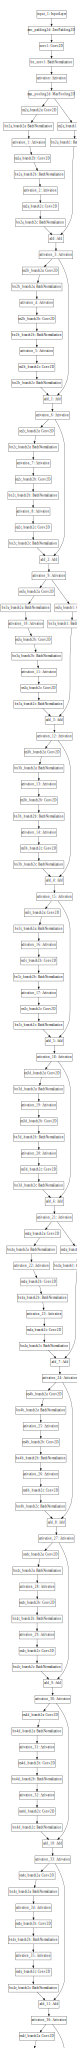

In [21]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

other model

In [21]:
model2 = ArdruResNet50(input_shape = (64,64,3), classes = 6)

In [22]:
model2.compile(optimizer = 'adam' ,loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [23]:
model2.fit(x=x_train, y=y_train, epochs = 20, batch_size = 32 , validation_data = (x_test, y_test))

Epoch 1/20
34/34 [==============================] - 169s 5s/step - loss: 3.4263 - accuracy: 0.3084 - val_loss: 2.2285 - val_accuracy: 0.2250
Epoch 2/20
34/34 [==============================] - 165s 5s/step - loss: 0.9184 - accuracy: 0.7925 - val_loss: 2.9495 - val_accuracy: 0.1667
Epoch 3/20
34/34 [==============================] - 169s 5s/step - loss: 0.5474 - accuracy: 0.8609 - val_loss: 3.7178 - val_accuracy: 0.1667
Epoch 4/20
21/34 [=================>............] - ETA: 1:04 - loss: 0.2603 - accuracy: 0.9193

KeyboardInterrupt: ignored

In [ ]:
model2.save_weights("saved_AndruModel")

In [ ]:
preds2 = model.evaluate(x_test, y_test)
print ("Loss = " + str(preds2[0]))
print ("Test Accuracy = " + str(preds2[1]))

In [20]:
from keras.models import load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
img_path = '/content/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
print(model.predict(x))

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))